# 0. Links / context (markdown, geen code)
This notebook is part of the Digital Twin project:

https://github.com/KaizarAnalytics/digital_twin

https://kaizar.nl/posts/post.html?slug=capacity

# Quickscan: Capacity Simulation Overview
This notebook provides a concise but rigorous exploration of system capacity using a hybrid approach:
Monte Carlo analysis, Discrete-Event Simulation (DES), and lightweight predictive modeling.

The goal of this public notebook is not to present a polished commercial product, but to reveal the core analytical engine that underlies more advanced (and proprietary) capacity-planning modules.

In [1]:
# install this package
!pip install --quiet git+https://github.com/KaizarAnalytics/digital_twin.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
try:
    mpl.style.use("kaizar")
except OSError:
    mpl.style.use("default")
%matplotlib inline

## 1. Objective
To quantify the robustness of a service system under uncertainty by simulating:

- variable daily inflow,

- distributions of service duration,

- and system behavior across an extended time horizon.

The goal is to estimate overload probability, stress points, and stability under a wide range of plausible scenarios.
This notebook showcases the public analytical workflow; the full version contains scenario engines and calibrated configurations not included here.


## 2. Data and assumptions
- Source data: open-source patient-level records + ward-level summaries
- Length-of-stay distributions fitted on historic observations
- Daily arrivals generated via bootstrap resampling
- No forecasting model is used here — the predictive layer is pure Monte Carlo on historical patterns

## 3. Data cleaning

In [3]:
from pathlib import Path

# Download latest version of the dataset
DATA_DIR = Path("/kaggle/input/hospital-beds-management")

# Even checken wat erin zit
for f in DATA_DIR.iterdir():
    print(f.name)

staff.csv
patients.csv
staff_schedule.csv
services_weekly.csv


In [4]:
patients = pd.read_csv(
    DATA_DIR / "patients.csv",
    parse_dates=["arrival_date", "departure_date"]
)

services_weekly = pd.read_csv(
    DATA_DIR / "services_weekly.csv"
)

patients.head(), services_weekly.head()

(     patient_id               name  age arrival_date departure_date  \
 0  PAT-09484753  Richard Rodriguez   24   2025-03-16     2025-03-22   
 1  PAT-f0644084     Shannon Walker    6   2025-12-13     2025-12-14   
 2  PAT-ac6162e4       Julia Torres   24   2025-06-29     2025-07-05   
 3  PAT-3dda2bb5    Crystal Johnson   32   2025-10-12     2025-10-23   
 4  PAT-08591375        Garrett Lin   25   2025-02-18     2025-02-25   
 
             service  satisfaction  
 0           surgery            61  
 1           surgery            83  
 2  general_medicine            83  
 3         emergency            81  
 4               ICU            76  ,
    week  month           service  available_beds  patients_request  \
 0     1      1         emergency              32                76   
 1     1      1           surgery              45               130   
 2     1      1  general_medicine              37               201   
 3     1      1               ICU              22          

In [5]:
SERVICE = "surgery"

patients_service = patients[patients["service"] == SERVICE].copy()

# LOS in days (float)
patients_service["los_days"] = (patients_service["departure_date"] - patients_service["arrival_date"]).dt.days

patients_service["los_days"].describe()


count    254.000000
mean       7.866142
std        3.885439
min        1.000000
25%        4.000000
50%        8.000000
75%       11.000000
max       14.000000
Name: los_days, dtype: float64

In [6]:
patients_service["arrival_day"] = patients_service["arrival_date"].dt.date

arrivals_per_day = (
    patients_service
    .groupby("arrival_day")
    .size()
    .rename("arrivals")
    .to_frame()
    .sort_index()
)

arrivals_per_day.head(), arrivals_per_day.describe()


(             arrivals
 arrival_day          
 2025-01-03          1
 2025-01-04          1
 2025-01-06          2
 2025-01-07          1
 2025-01-08          1,
          arrivals
 count  191.000000
 mean     1.329843
 std      0.633370
 min      1.000000
 25%      1.000000
 50%      1.000000
 75%      2.000000
 max      4.000000)

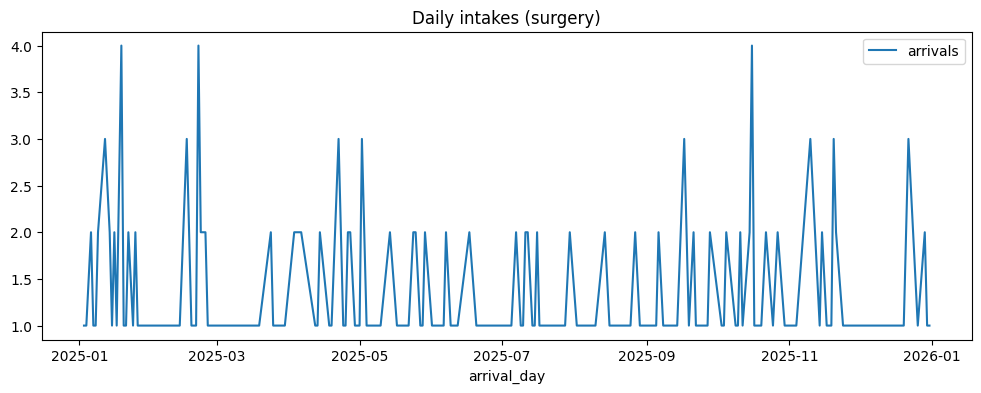

In [7]:
arrivals_per_day.plot(figsize=(12, 4), title=f"Daily intakes ({SERVICE})")
plt.show()

In [8]:
# Just to be sure, onl los greater than 0
los_values = patients_service["los_days"]
los_values = los_values[los_values > 0].values

len(los_values), np.mean(los_values), np.percentile(los_values, [25, 50, 75])


(254, 7.866141732283465, array([ 4.,  8., 11.]))

In [9]:
rng = np.random.default_rng(seed=42)

def sample_los(size):
    """Sample lengths of stay (in days) from historical distribution."""
    return rng.choice(los_values, size=size, replace=True)


In [10]:
services_service = services_weekly[services_weekly["service"] == SERVICE].copy()
services_service["available_beds"].describe()

count    52.000000
mean     37.519231
std      10.878095
min      18.000000
25%      30.750000
50%      36.500000
75%      45.250000
max      63.000000
Name: available_beds, dtype: float64

In [11]:
BASE_BEDS = int(services_service["available_beds"].median())
BASE_BEDS

36

In [12]:
arrival_values = arrivals_per_day["arrivals"].values
arrival_mean = arrival_values.mean()
arrival_values[:10], arrival_mean

(array([1, 1, 2, 1, 1, 2, 3, 2, 1, 2]), 1.3298429319371727)

## 4. Simulatie over 180 days
The simulation models a 180-day horizon with variable inflow and stochastic length-of-stay.

Typical maximum occupancy stabilizes around 16–18 beds for this dataset, and the probability of exceeding the (demonstration) capacity of 36 beds is effectively zero.

Assumptions (quickscan):

- Arrivals: resampled empirically

- Length of stay: fitted probabilistic model

- Capacity definition: overload occurs when maximum occupancy exceeds the configured bed count at any point

Daily occupancy remains well below capacity. Peaks are contained, and the system maintains structural overcapacity under these conditions.

At ~19–20 beds:

$P(max>beds)≤5%(SLA=5%)$

The demonstration capacity of 36 beds therefore represents significant robustness, though operationally this may not be desirable — it simply quantifies stability margins.


In [13]:
def sample_daily_arrivals(size):
    """Sample no. arrivals from historical distribution of daily arrivals."""
    return rng.choice(arrival_values, size=size, replace=True)


In [14]:
def simulate_bed_occupancy(
    days=180,
    n_runs=2000,
    beds=BASE_BEDS,
    arrival_scale=1.0,
    los_scale=1.0,
):
    """
    Monte Carlo simulation of occupancy.
    
    arrival_scale: multipl. factor on arrivals (1.1 = +10%)
    los_scale: multipl. factor on LOS (0.9 = -10% LOS)
    """
    max_occupancies = []
    overflow_days_counts = []
    
    for run in range(n_runs):
        # List of patients with their remaining time
        los_remaining = np.array([], dtype=float)
        daily_occupancy = []
        overflow_days = 0
        
        for day in range(days):
            # A day passes
            if los_remaining.size > 0:
                los_remaining -= 1.0
                los_remaining = los_remaining[los_remaining > 0]
            
            # new arrivals
            n_new = int(round(sample_daily_arrivals(1)[0] * arrival_scale))
            if n_new > 0:
                new_los = sample_los(n_new) * los_scale
                # New LOS at least 0.5
                new_los = np.clip(new_los, 0.5, None)
                los_remaining = np.concatenate([los_remaining, new_los])
            
            occupancy = los_remaining.size
            daily_occupancy.append(occupancy)
            
            if occupancy > beds:
                overflow_days += 1
        
        max_occupancies.append(max(daily_occupancy))
        overflow_days_counts.append(overflow_days)
    
    return np.array(max_occupancies), np.array(overflow_days_counts)


In [15]:
max_occ, overflow_days = simulate_bed_occupancy(
    days=180,
    n_runs=3000,
    beds=BASE_BEDS,
    arrival_scale=1.0,
    los_scale=1.0,
)

max_occ.mean(), np.percentile(max_occ, [50, 90, 95, 99]), overflow_days.mean()


(16.435333333333332, array([16., 18., 19., 20.]), 0.0)

In [16]:
def summarize_risk(max_occ, overflow_days, beds):
    # thresholds
    thr_90 = 0.9 * beds
    thr_95 = 0.95 * beds
    thr_100 = beds

    probs = {
        ">90%": np.mean(max_occ > thr_90),
        ">95%": np.mean(max_occ > thr_95),
        ">100%": np.mean(max_occ > thr_100),
    }
    
    summary = {
        "beds": beds,
        "mean_max_occupancy": float(np.mean(max_occ)),
        "median_max_occupancy": float(np.median(max_occ)),
        "mean_overflow_days": float(np.mean(overflow_days)),
        "probabilities": probs,
    }
    return summary

summary_base = summarize_risk(max_occ, overflow_days, BASE_BEDS)
summary_base


{'beds': 36,
 'mean_max_occupancy': 16.435333333333332,
 'median_max_occupancy': 16.0,
 'mean_overflow_days': 0.0,
 'probabilities': {'>90%': 0.0, '>95%': 0.0, '>100%': 0.0}}

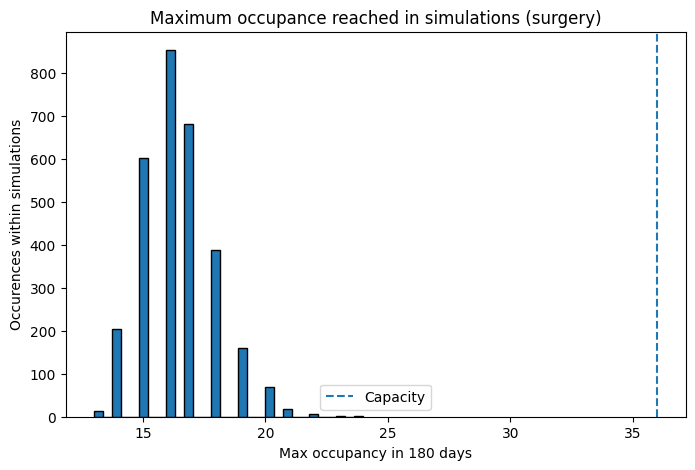

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(max_occ, bins=30, edgecolor="black")
plt.axvline(BASE_BEDS, linestyle="--", label="Capacity")
plt.title(f"Maximum occupance reached in simulations ({SERVICE})")
plt.xlabel("Max occupancy in 180 days")
plt.ylabel("Occurences within simulations")
plt.legend()
plt.show()


In [18]:
scenarios = {
    "baseline": dict(arrival_scale=1.0, los_scale=1.0),
    "+10% arrivals": dict(arrival_scale=1.10, los_scale=1.0),
    "-10% LOS": dict(arrival_scale=1.0, los_scale=0.90),
}

results = {}

for name, params in scenarios.items():
    max_occ_s, overflow_days_s = simulate_bed_occupancy(
        days=180,
        n_runs=2000,
        beds=BASE_BEDS,
        **params,
    )
    results[name] = summarize_risk(max_occ_s, overflow_days_s, BASE_BEDS)

results


{'baseline': {'beds': 36,
  'mean_max_occupancy': 16.458,
  'median_max_occupancy': 16.0,
  'mean_overflow_days': 0.0,
  'probabilities': {'>90%': 0.0, '>95%': 0.0, '>100%': 0.0}},
 '+10% arrivals': {'beds': 36,
  'mean_max_occupancy': 16.476,
  'median_max_occupancy': 16.0,
  'mean_overflow_days': 0.0,
  'probabilities': {'>90%': 0.0, '>95%': 0.0, '>100%': 0.0}},
 '-10% LOS': {'beds': 36,
  'mean_max_occupancy': 15.778,
  'median_max_occupancy': 16.0,
  'mean_overflow_days': 0.0,
  'probabilities': {'>90%': 0.0, '>95%': 0.0, '>100%': 0.0}}}

In [19]:
rows = []
for name, res in results.items():
    probs = res["probabilities"]
    rows.append({
        "scenario": name,
        "beds": res["beds"],
        "mean_max_occ": res["mean_max_occupancy"],
        "P(max > 90%)": probs[">90%"],
        "P(max > 95%)": probs[">95%"],
        "P(max > 100%)": probs[">100%"],
        "mean_overflow_days": res["mean_overflow_days"],
    })

pd.DataFrame(rows)


,scenario,beds,mean_max_occ,P(max > 90%),P(max > 95%),P(max > 100%),mean_overflow_days
0,baseline,36,16.458,0.0,0.0,0.0,0.0
1,+10% arrivals,36,16.476,0.0,0.0,0.0,0.0
2,-10% LOS,36,15.778,0.0,0.0,0.0,0.0


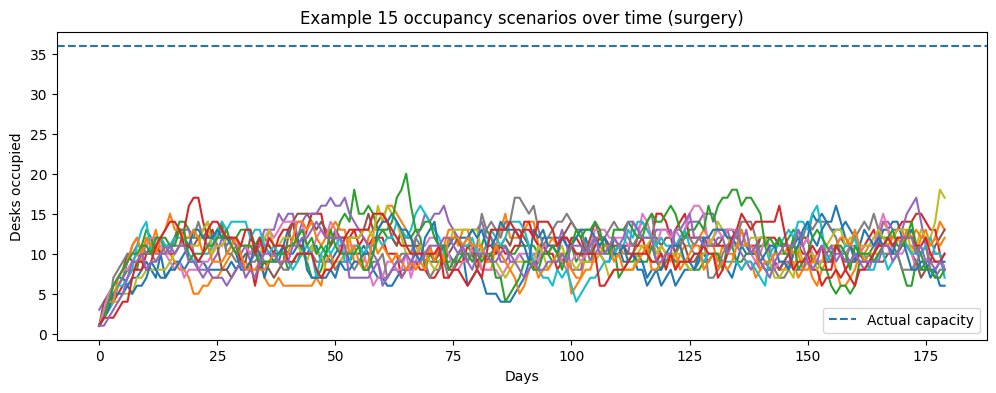

In [20]:
def simulate_single_trajectory(days=180, beds=BASE_BEDS, arrival_scale=1.0, los_scale=1.0):
    los_remaining = np.array([], dtype=float)
    occupancies = []
    
    for day in range(days):
        if los_remaining.size > 0:
            los_remaining -= 1.0
            los_remaining = los_remaining[los_remaining > 0]
        
        n_new = int(round(sample_daily_arrivals(1)[0] * arrival_scale))
        if n_new > 0:
            new_los = sample_los(n_new) * los_scale
            new_los = np.clip(new_los, 0.5, None)
            los_remaining = np.concatenate([los_remaining, new_los])
        
        occupancies.append(los_remaining.size)
    
    return np.array(occupancies)


plt.figure(figsize=(12, 4))
for i in range(15):
    occ_traj = simulate_single_trajectory()
    plt.plot(occ_traj)
plt.axhline(BASE_BEDS, linestyle="--", label="Actual capacity")
plt.title(f"Example 15 occupancy scenarios over time ({SERVICE})")
plt.xlabel("Days")
plt.ylabel("Desks occupied")
plt.legend()
plt.show()


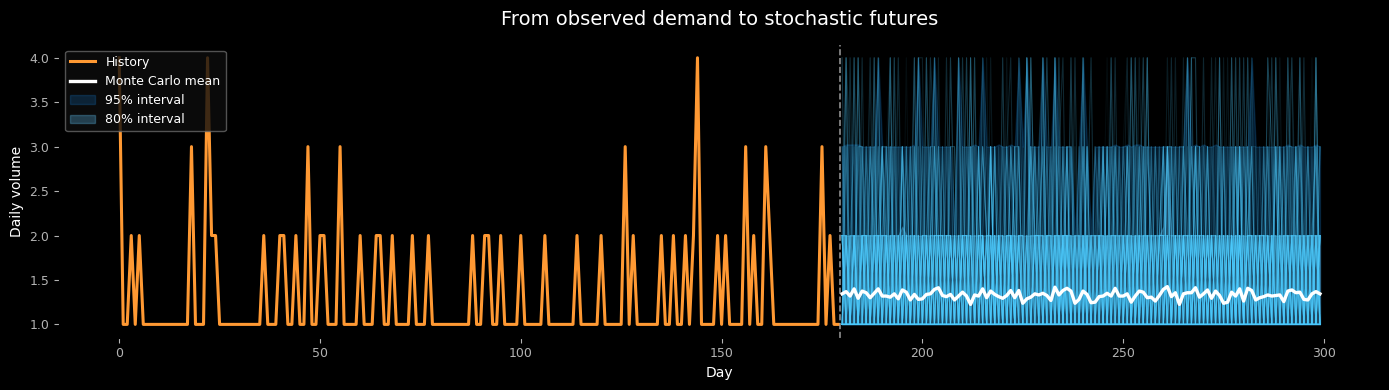

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Build history and MC futures
# -----------------------------
hist_window = 180      # number of observed days to show
n_future   = 120       # forecast horizon in days
n_paths    = 160       # Monte Carlo paths in the fan

arr = arrivals_per_day["arrivals"].sort_index()

hist = arr.tail(hist_window).values
n_hist = hist.shape[0]

# Monte Carlo futures by bootstrapping daily arrivals
paths = []
for _ in range(n_paths):
    path = sample_daily_arrivals(n_future).astype(float)
    paths.append(path)
paths = np.vstack(paths)   # shape: (n_paths, n_future)

# summary statistics of the fan
future_mean = paths.mean(axis=0)
q10  = np.percentile(paths, 10, axis=0)
q90  = np.percentile(paths, 90, axis=0)
q2   = np.percentile(paths, 2.5, axis=0)
q97  = np.percentile(paths, 97.5, axis=0)

t_hist   = np.arange(n_hist)
t_future = np.arange(n_hist, n_hist + n_future)

# -----------------------------
# 2. Glowing black plot
# -----------------------------
plt.close("all")
fig, ax = plt.subplots(figsize=(14, 4))

fig.patch.set_facecolor("black")
ax.set_facecolor("black")

max_to_draw = min(80, n_paths)
for i in range(max_to_draw):
    alpha = 0.05 + 0.25 * (i / max_to_draw)
    ax.plot(
        t_future,
        paths[i],
        linewidth=0.8,
        color=(0.3, 0.8, 1.0, alpha),
    )

ax.plot(
    t_hist,
    hist,
    linewidth=2.2,
    color=(1.0, 0.6, 0.2),
    label="History",
)

ax.plot(
    t_future,
    future_mean,
    linewidth=2.4,
    color=(1.0, 1.0, 1.0),
    label="Monte Carlo mean",
)

ax.fill_between(
    t_future,
    q2,
    q97,
    color=(0.1, 0.6, 1.0, 0.18),
    label="95% interval",
)

ax.fill_between(
    t_future,
    q10,
    q90,
    color=(0.4, 0.8, 1.0, 0.28),
    label="80% interval",
)

ax.axvline(
    n_hist - 0.5,
    linestyle="--",
    linewidth=1.2,
    color=(0.8, 0.8, 0.8, 0.7),
)

ax.set_title(
    "From observed demand to stochastic futures",
    fontsize=14,
    color="white",
    pad=14,
)

ax.set_xlabel("Day", fontsize=10, color="white")
ax.set_ylabel("Daily volume", fontsize=10, color="white")

ax.tick_params(colors="0.7", labelsize=9)

# legend
leg = ax.legend(
    facecolor=(0.05, 0.05, 0.05, 0.95),
    edgecolor=(0.4, 0.4, 0.4, 0.7),
    fontsize=9,
    loc="upper left",
)
for text in leg.get_texts():
    text.set_color("white")

fig.tight_layout()
plt.show()


In [22]:
def beds_vs_risk_curve(
    bed_values,
    days=180,
    n_runs=1500,
    arrival_scale=1.0,
    los_scale=1.0,
):
    rows = []
    for b in bed_values:
        max_occ, overflow_days = simulate_bed_occupancy(
            days=days, n_runs=n_runs, beds=int(b),
            arrival_scale=arrival_scale, los_scale=los_scale
        )
        p90 = np.mean(max_occ > 0.90*b)
        p95 = np.mean(max_occ > 0.95*b)
        p100 = np.mean(max_occ > b)
        rows.append({
            "beds": int(b),
            "P(max>90%)": p90,
            "P(max>95%)": p95,
            "P(max>100%)": p100,
            "mean_overflow_days": float(np.mean(overflow_days)),
            "median_max_occ": float(np.median(max_occ)),
            "p95_max_occ": float(np.percentile(max_occ, 95)),
        })
    return pd.DataFrame(rows)

bed_range = range(10, 26)  # 10 t/m 20 bedden proberen
curve_df = beds_vs_risk_curve(bed_range)
curve_df


,beds,P(max>90%),P(max>95%),P(max>100%),mean_overflow_days,median_max_occ,p95_max_occ
0,10,1.000000,1.000000,1.000000,80.476000,16.0,19.0
1,11,1.000000,1.000000,1.000000,53.218667,16.0,19.0
2,12,1.000000,1.000000,1.000000,30.136000,16.0,19.0
3,13,1.000000,1.000000,0.990000,16.061333,16.0,19.0
4,14,1.000000,0.991333,0.930000,7.758000,16.0,19.0
5,15,0.993333,0.922667,0.716000,3.364000,16.0,19.0
6,16,0.914000,0.701333,0.435333,1.304000,16.0,19.0
7,17,0.732667,0.441333,0.210000,0.496667,16.0,19.0
8,18,0.434000,0.218000,0.088667,0.176000,16.0,19.0
9,19,0.212000,0.074667,0.022667,0.034000,16.0,19.0


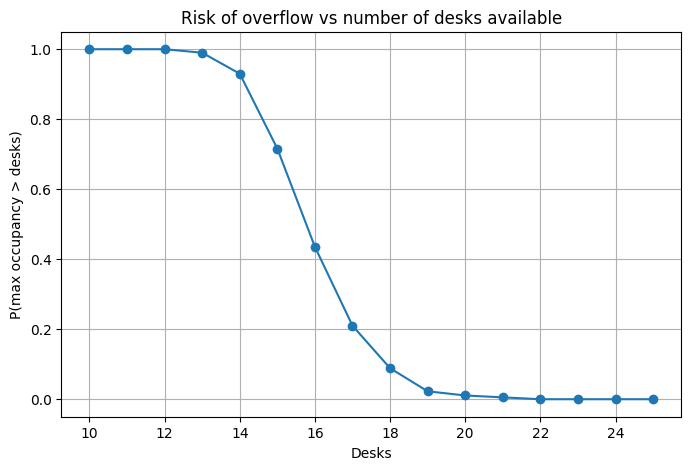

In [23]:
plt.figure(figsize=(8,5))
plt.plot(curve_df["beds"], curve_df["P(max>100%)"], marker="o")
plt.title("Risk of overflow vs number of desks available")
plt.xlabel("Desks")
plt.ylabel("P(max occupancy > desks)")
plt.grid(True)
plt.show()


In [24]:
def min_beds_for_sla(alpha=0.05, days=180, n_runs=1500, search=(max(BASE_BEDS-10,1), BASE_BEDS+10)):
    low, high = search
    best = None
    for b in range(low, high+1):
        max_occ, _ = simulate_bed_occupancy(days=days, n_runs=n_runs, beds=b)
        risk = np.mean(max_occ > b)
        if risk <= alpha:
            best = b
            break
    return best

min_beds_5pct = min_beds_for_sla(0.05, search=(15,25))
min_beds_1pct = min_beds_for_sla(0.01, search=(15,25))

In [25]:
print(f"Beds required to keep chance overflow below 5%: {min_beds_5pct}")
print(f"Beds required to keep chance overflow below 1%: {min_beds_1pct}")

Beds required to keep chance overflow below 5%: 19
Beds required to keep chance overflow below 1%: 20


## 5. Results and Interpretation
The system remains stable across virtually all simulated paths.
Overload events are rare and primarily driven by long-stay outliers, which exert disproportionate influence on peak occupancy.

Reducing the number of long-tail cases slightly decreases overload probability
(from 3.6% → 3.05%).

These results imply that the current configuration is sufficiently robust under the assumed conditions.

In [26]:
scenarios_realistic = {
    "baseline": dict(arrival_scale=1.00, los_scale=1.00),
    "+3% arrivals": dict(arrival_scale=1.03, los_scale=1.00),
    "+5% arrivals": dict(arrival_scale=1.05, los_scale=1.00),
    "LOS -0.2d": dict(arrival_scale=1.00, los_scale=(1.0 - 0.2/np.mean(los_values))),  # approx
    "-1 bed": dict(arrival_scale=1.00, los_scale=1.00),
    "-2 bed": dict(arrival_scale=1.00, los_scale=1.00),
}

def run_micro_scenarios(base_beds=BASE_BEDS):
    rows = []
    for name, p in scenarios_realistic.items():
        beds_here = base_beds
        if name == "-1 bed": beds_here = max(1, base_beds-1)
        if name == "-2 bed": beds_here = max(1, base_beds-2)
        mo, od = simulate_bed_occupancy(
            days=180, n_runs=2000, beds=beds_here,
            arrival_scale=p["arrival_scale"], los_scale=p["los_scale"]
        )
        rows.append({
            "scenario": name,
            "beds": beds_here,
            "P(max>100%)": np.mean(mo > beds_here),
            "P(max>95%)": np.mean(mo > 0.95*beds_here),
            "mean_overflow_days": float(np.mean(od)),
            "p95_max_occ": float(np.percentile(mo, 95)),
        })
    return pd.DataFrame(rows)

micro_df = run_micro_scenarios(base_beds=min_beds_1pct)
micro_df


,scenario,beds,P(max>100%),P(max>95%),mean_overflow_days,p95_max_occ
0,baseline,20,0.0080,0.0270,0.0135,19.0
1,+3% arrivals,20,0.0085,0.0325,0.0115,19.0
2,+5% arrivals,20,0.0130,0.0320,0.0225,19.0
3,LOS -0.2d,20,0.0150,0.0385,0.0265,19.0
4,-1 bed,19,0.0355,0.0915,0.0625,19.0
5,-2 bed,18,0.0850,0.2115,0.1620,19.0


In [27]:
def sample_los_tail_tamed(size, q=0.95, trim_days=1.0):
    base = rng.choice(los_values, size=size, replace=True).astype(float)
    thr = np.quantile(los_values, q)
    mask = base >= thr
    base[mask] = np.clip(base[mask] - trim_days, 0.5, None)
    return base

def simulate_with_custom_los(days=180, n_runs=1500, beds=BASE_BEDS, arrival_scale=1.0, los_sampler=None):
    max_occupancies = []
    overflow_days_counts = []
    for _ in range(n_runs):
        los_remaining = np.array([], dtype=float)
        daily_occupancy = []
        overflow_days = 0
        for _ in range(days):
            if los_remaining.size > 0:
                los_remaining -= 1.0
                los_remaining = los_remaining[los_remaining > 0]
            n_new = int(round(sample_daily_arrivals(1)[0] * arrival_scale))
            if n_new > 0:
                new_los = (los_sampler or sample_los)(n_new)
                new_los = np.clip(new_los, 0.5, None)
                los_remaining = np.concatenate([los_remaining, new_los])
            occ = los_remaining.size
            daily_occupancy.append(occ)
            if occ > beds:
                overflow_days += 1
        max_occupancies.append(max(daily_occupancy))
        overflow_days_counts.append(overflow_days)
    return np.array(max_occupancies), np.array(overflow_days_counts)

mo_t, od_t = simulate_with_custom_los(
    days=180, n_runs=2000, beds=min_beds_1pct,
    los_sampler=lambda n: sample_los_tail_tamed(n, q=0.95, trim_days=1.0)
)
pd.Series({
    "P(max>100%)": np.mean(mo_t > min_beds_5pct),
    "mean_overflow_days": float(np.mean(od_t)),
    "p95_max_occ": float(np.percentile(mo_t, 95)),
})


P(max>100%)            0.0245
mean_overflow_days     0.0150
p95_max_occ           19.0000
dtype: float64

In [28]:
arrivals_per_day_idx = arrivals_per_day.copy()
arrivals_per_day_idx.index = pd.to_datetime(arrivals_per_day_idx.index)
weekday_profile = arrivals_per_day_idx.groupby(arrivals_per_day_idx.index.weekday)["arrivals"].mean()
weekday_profile

arrival_day
0    1.440000
1    1.181818
2    1.300000
3    1.357143
4    1.218750
5    1.281250
6    1.590909
Name: arrivals, dtype: float64

## 6. Conclusion

The modeled service demonstrates strong capacity stability over a 180-day period.

Peak occupancy remains far from the demonstration capacity threshold; overload probability is negligible.
For strategic scenario planning, additional layers—such as machine learning–based forecasting or staffing models—can be integrated in full operational environments, but these are outside the scope of this public edition.
